In [1]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from time import clock
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans as kmeans
from sklearn.mixture import GaussianMixture as GMM
from collections import defaultdict
#from helpers import cluster_acc, myGMM,nn_arch,nn_reg
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import sys
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(0)

In [3]:
PATH = '/Users/shuyi/Documents/OMSCS-master/MachineLearning/HW1/swang705/Data/mentalHealthData/'
TRAIN_DATA_FILE = "step1.csv"
data_mental = pd.read_csv(PATH+TRAIN_DATA_FILE)

In [4]:
del data_mental["Unnamed: 0"]
data_mental.head()

,Gender,Country,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,Age Category
0,female,United States,No,Yes,Often,6-25,No,Yes,Yes,Not sure,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,40
1,male,United States,No,No,Rarely,More than 1000,No,No,Don't know,No,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,60
2,male,Canada,No,No,Rarely,6-25,No,Yes,No,No,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,40
3,male,United Kingdom,Yes,Yes,Often,26-100,No,Yes,No,Yes,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,40
4,male,United States,No,No,Never,100-500,Yes,Yes,Yes,No,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,40


In [5]:
target_y = data_mental["treatment"]
train_x = data_mental.copy().drop(["treatment"], 1)

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(target_y)
target_y = le.transform(target_y) 

In [7]:
col_selected = ['Gender', 'family_history', 'work_interfere', 'benefits', 'care_options', 'anonymity' ]
train_x_selected = train_x[col_selected]
train_x_selected[:5]

,Gender,family_history,work_interfere,benefits,care_options,anonymity
0,female,No,Often,Yes,Not sure,Yes
1,male,No,Rarely,Don't know,No,Don't know
2,male,No,Rarely,No,No,Don't know
3,male,Yes,Often,No,Yes,No
4,male,No,Never,Yes,No,Don't know


In [8]:
train_x_selected = pd.get_dummies(train_x_selected, columns=["Gender",])
train_x_selected = pd.get_dummies(train_x_selected, columns=["family_history", "work_interfere", "benefits", "care_options", "anonymity"])
train_x_selected.head()

,Gender_female,Gender_genderqueer,Gender_male,Gender_trans female,family_history_No,family_history_Yes,work_interfere_Never,work_interfere_Often,work_interfere_Rarely,work_interfere_Sometimes,benefits_Don't know,benefits_No,benefits_Yes,care_options_No,care_options_Not sure,care_options_Yes,anonymity_Don't know,anonymity_No,anonymity_Yes
0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1
1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0
2,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0
3,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0
4,0,0,1,0,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0


In [9]:
data_mental.columns

Index(['Gender', 'Country', 'family_history', 'treatment', 'work_interfere',
       'no_employees', 'remote_work', 'tech_company', 'benefits',
       'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence', 'Age Category'],
      dtype='object')

In [10]:
clusters =  [2,5,10,15,20,25,30,35,40,45,50]

In [14]:
SSE = defaultdict(dict)
ll = defaultdict(dict)
acc = defaultdict(lambda: defaultdict(dict))
adjMI = defaultdict(lambda: defaultdict(dict))
km = kmeans(random_state=10)
gmm = GMM(random_state=10) # Gaussian Matrix

In [15]:
# use different random seed for Kmeans and EM to plot the results
seeds = [0,10,20,30]
for s in seeds:
    for k in clusters:
        km.set_params(n_clusters=k, random_state=s)
        gmm.set_params(n_components=k, random_state=s)
        km.fit(train_x_selected)
        #Using the GaussianMixture class of scikit-learn, we can easily create a GMM and run the EM algorithm
        gmm.fit(train_x_selected)
        SSE[k]['Mental'+str(s)] = km.score(train_x_selected)
        ll[k]['Mental'+str(s)] = gmm.score(train_x_selected)    
        adjMI[k]['Mental']['Kmeans'+str(s)] = ami(target_y,km.predict(train_x_selected))
        adjMI[k]['Mental']['GMM'+str(s)] = ami(target_y,gmm.predict(train_x_selected))

In [16]:
SSE = (-pd.DataFrame(SSE)).T
#SSE.rename(columns = lambda x: str(x),inplace=True)
ll = pd.DataFrame(ll).T
#ll.rename(columns = lambda x: str(x) +' log-likelihood',inplace=True)
#adjMI = pd.Panel(adjMI)

In [17]:
SSE

,Mental0,Mental10,Mental20,Mental30
2,3333.563714,3333.787090,3333.563714,3333.761696
5,2447.159036,2441.267966,2451.024141,2441.267966
10,1872.301727,1907.510067,1874.180806,1904.884631
15,1577.509072,1574.118448,1592.588520,1607.661691
20,1373.658828,1408.373268,1407.609257,1379.654299
25,1250.341992,1261.031993,1255.282191,1249.553909
30,1131.613429,1128.492937,1118.701010,1128.621415
35,1013.785258,1021.240074,1024.631176,1011.739243
40,940.469453,936.238275,916.188140,947.929455
45,861.761348,846.978052,861.674912,851.794657


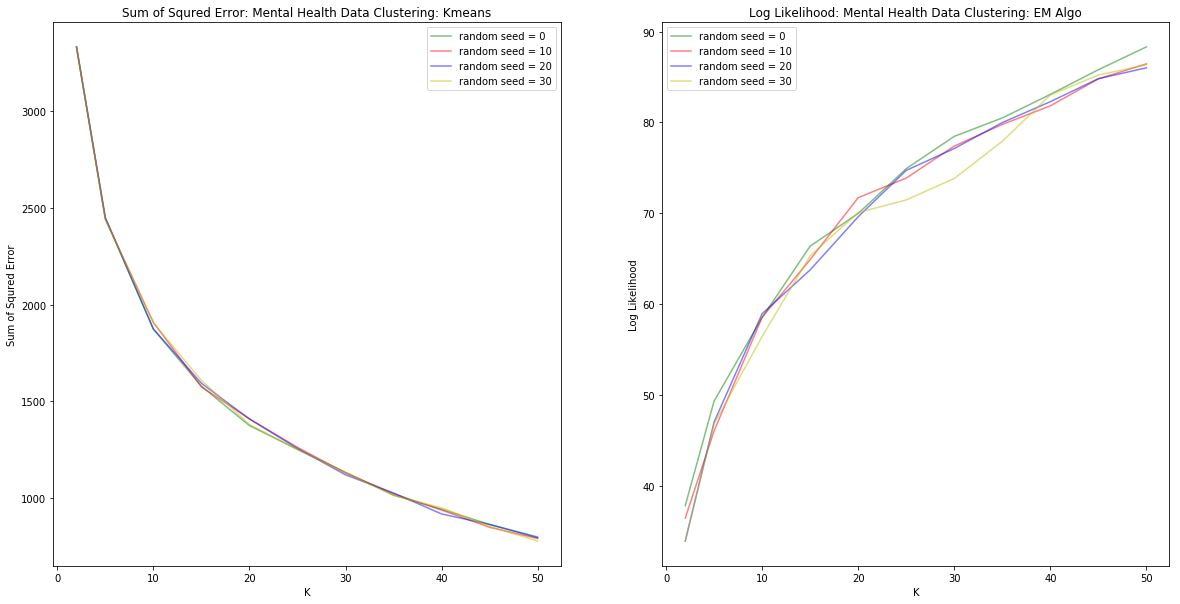

In [18]:
plt.figure(figsize=(20,10))
#sns.set_style("whitegrid")
plt.subplot(121)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(clusters, SSE['Mental0'], color="g", alpha=0.5, label='random seed = 0')
plt.plot(clusters, SSE['Mental10'], color = 'r', alpha = 0.5, label='random seed = 10')
plt.plot(clusters, SSE['Mental20'], color="b", alpha=0.5, label='random seed = 20')
plt.plot(clusters, SSE['Mental30'], color="y", alpha=0.5, label='random seed = 30')
plt.legend()
plt.title("Sum of Squred Error: Mental Health Data Clustering: Kmeans")
plt.xlabel("K")
plt.ylabel("Sum of Squred Error")

plt.subplot(122)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(clusters, ll['Mental0'], color="g", alpha=0.5, label='random seed = 0')
plt.plot(clusters, ll['Mental10'], color = 'r', alpha = 0.5, label='random seed = 10')
plt.plot(clusters, ll['Mental20'], color="b", alpha=0.5, label='random seed = 20')
plt.plot(clusters, ll['Mental30'], color="y", alpha=0.5,label='random seed = 30')
plt.legend()
plt.title("Log Likelihood: Mental Health Data Clustering: EM Algo")
plt.xlabel("K")
plt.ylabel("Log Likelihood")


plt.show()

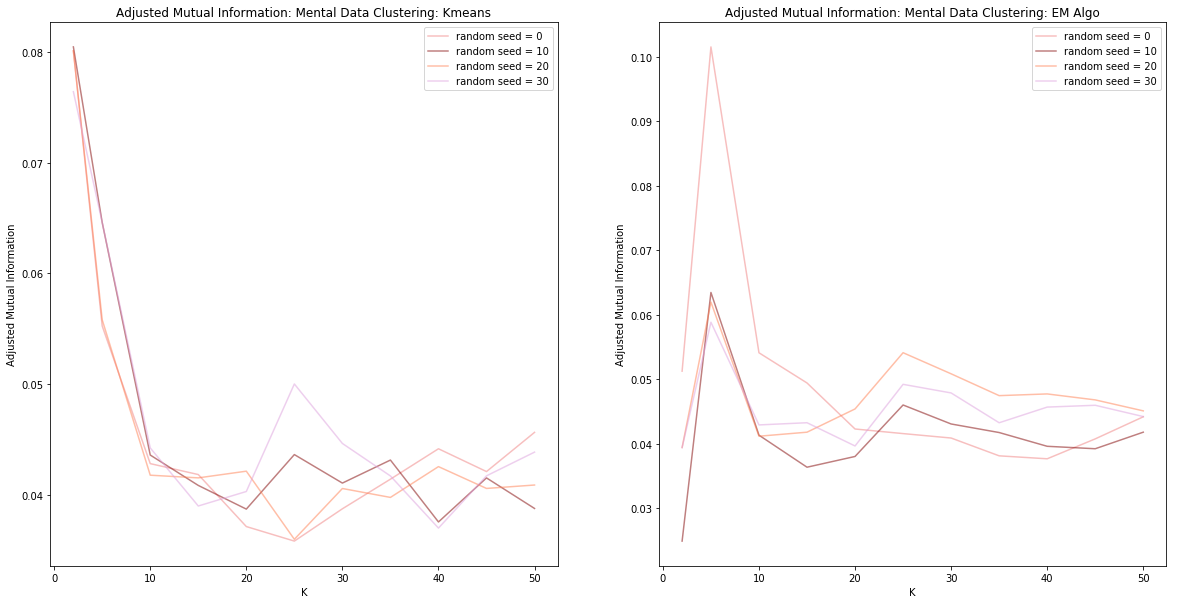

In [19]:
plt.figure(figsize=(20,10))
#sns.set_style("whitegrid")
plt.subplot(121)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
adj_k0 = []
adj_k10 = []
adj_k20 = []
adj_k30 = []
for k in clusters:
    adj_k0.append(adjMI[k]['Mental']['Kmeans0'])
    adj_k10.append(adjMI[k]['Mental']['Kmeans10'])
    adj_k20.append([adjMI[k]['Mental']['Kmeans20']])
    adj_k30.append([adjMI[k]['Mental']['Kmeans30']])
plt.plot(clusters, adj_k0, color="lightcoral", alpha=0.5, label='random seed = 0')
plt.plot(clusters, adj_k10, color = 'maroon', alpha = 0.5, label='random seed = 10')
plt.plot(clusters, adj_k20, color="coral", alpha=0.5, label='random seed = 20')
plt.plot(clusters, adj_k30, color="plum", alpha=0.5, label='random seed = 30')
plt.legend()
plt.title("Adjusted Mutual Information: Mental Data Clustering: Kmeans")
plt.xlabel("K")
plt.ylabel("Adjusted Mutual Information")

plt.subplot(122)
adj_em0 = []
adj_em10 = []
adj_em20 = []
adj_em30 = []
for k in clusters:
    adj_em0.append(adjMI[k]['Mental']['GMM0'])
    adj_em10.append(adjMI[k]['Mental']['GMM10'])
    adj_em20.append([adjMI[k]['Mental']['GMM20']])
    adj_em30.append([adjMI[k]['Mental']['GMM30']])

plt.plot(clusters, adj_em0, color="lightcoral", alpha=0.5, label='random seed = 0')
plt.plot(clusters, adj_em10, color = 'maroon', alpha = 0.5, label='random seed = 10')
plt.plot(clusters, adj_em20, color="coral", alpha=0.5, label='random seed = 20')
plt.plot(clusters, adj_em30, color="plum", alpha=0.5,label='random seed = 30')
plt.legend()
plt.title("Adjusted Mutual Information: Mental Data Clustering: EM Algo")
plt.xlabel("K")
plt.ylabel("Adjusted Mutual Information")


plt.show()


In [13]:
# use different random seed for Kmeans and EM to plot the results
km = kmeans(random_state=10)
gmm = GMM(random_state=10) # Gaussian Matrix
km.set_params(n_clusters=20, random_state=10)
gmm.set_params(n_components=20, random_state=10)
km.fit(train_x_selected)
#Using the GaussianMixture class of scikit-learn, we can easily create a GMM and run the EM algorithm
gmm.fit(train_x_selected)
km_y = km.predict(train_x_selected)
em_y = gmm.predict(train_x_selected)

Text(0.5,1,'Mental Health Data: Clusters')

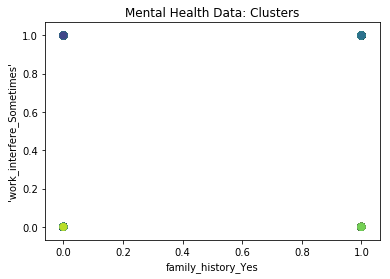

In [16]:
plt.scatter(train_x_selected['family_history_Yes'], train_x_selected['work_interfere_Sometimes'], c=km_y, s=50, cmap='viridis')
plt.xlabel("family_history_Yes")
plt.ylabel("'work_interfere_Sometimes'")
plt.title("Mental Health Data: Clusters")

In [15]:
km_y

array([ 9,  4,  8, ..., 10, 17,  7], dtype=int32)

Dimension Reduction

PCA

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#from helpers import  nn_arch,nn_reg
from matplotlib import cm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [21]:
np.random.seed(0)
#raise
#%% data for 1

pca = PCA(random_state=5, n_components=19)
pca.fit(train_x_selected)
tmp = pd.Series(data = pca.explained_variance_,index = range(1,20))
#tmp.to_csv(out+'madelon scree.csv')
tmp

1     7.295763e-01
2     4.960314e-01
3     4.089111e-01
4     2.931829e-01
5     2.617872e-01
6     2.565984e-01
7     2.327740e-01
8     1.493653e-01
9     1.420341e-01
10    1.194074e-01
11    6.694946e-02
12    3.546919e-02
13    1.752848e-02
14    1.043998e-03
15    8.568871e-32
16    2.120768e-32
17    1.015498e-32
18    6.158973e-33
19    2.824113e-35
dtype: float64

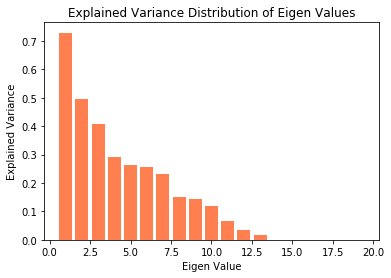

In [22]:
plt.figure()
plt.bar(np.arange(1,20,1),tmp, align='center', color = 'coral')
plt.ylabel('Explained Variance')
plt.xlabel('Eigen Value')
plt.title('Explained Variance Distribution of Eigen Values')
plt.show()

In [31]:
SSE_pca = defaultdict(dict)
ll_pca = defaultdict(dict)
#adjMI_pca = defaultdict(lambda: defaultdict(dict))
km = kmeans(random_state=10)
gmm = GMM(random_state=10) # Gaussian Matrix
km_pca = kmeans(random_state=10)
gmm_pca = GMM(random_state=10) # Gaussian Matrix

d = 10
reduced_mental_data = PCA(n_components=d).fit_transform(train_x_selected)
for k in clusters:
        km.set_params(n_clusters=k, random_state=10)
        km_pca.set_params(n_clusters=k, random_state=10)
        gmm.set_params(n_components=k, random_state=10)
        gmm_pca.set_params(n_components=k, random_state=10)
        
        km.fit(train_x_selected)
        km_pca.fit(reduced_mental_data)
        #Using the GaussianMixture class of scikit-learn, we can easily create a GMM and run the EM algorithm
        gmm.fit(train_x_selected)
        gmm_pca.fit(reduced_mental_data)
        SSE_pca[k]['original'] = km.score(train_x_selected)
        SSE_pca[k]['pca'] = km_pca.score(reduced_mental_data)
        ll_pca[k]['original'] = gmm.score(train_x_selected) 
        ll_pca[k]['pca'] = gmm_pca.score(reduced_mental_data)    



In [33]:
SSE_pca = (-pd.DataFrame(SSE_pca)).T
#SSE.rename(columns = lambda x: str(x),inplace=True)
ll_pca = pd.DataFrame(ll_pca).T
SSE_pca

,original,pca
2,3333.787090,3182.024139
5,2441.267966,2321.838487
10,1907.510067,1726.580760
15,1574.118448,1439.891960
20,1408.373268,1271.966031
25,1261.031993,1111.433919
30,1128.492937,991.048170
35,1021.240074,888.275166
40,936.238275,771.207334
45,846.978052,696.383375


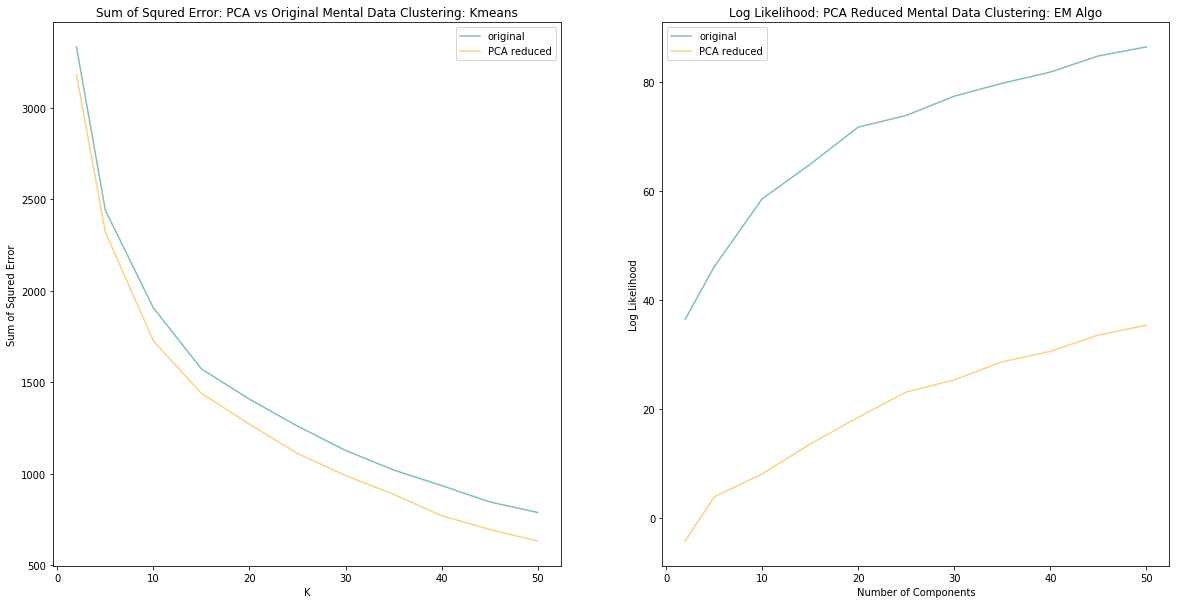

In [34]:
plt.figure(figsize=(20,10))
#sns.set_style("whitegrid")
plt.subplot(121)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(clusters, SSE_pca['original'],  alpha=0.5, label = 'original', color = 'teal')
plt.plot(clusters, SSE_pca['pca'],  alpha=0.5, label = 'PCA reduced', color = 'orange')
plt.title("Sum of Squred Error: PCA vs Original Mental Data Clustering: Kmeans")
plt.xlabel("K")
plt.ylabel("Sum of Squred Error")
plt.legend()
plt.subplot(122)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(clusters, ll_pca['original'], alpha=0.5, label = 'original', color = 'teal')
plt.plot(clusters, ll_pca['pca'], alpha=0.5, label = 'PCA reduced', color = 'orange')
plt.title("Log Likelihood: PCA Reduced Mental Data Clustering: EM Algo")
plt.xlabel("Number of Components")
plt.ylabel("Log Likelihood")
plt.legend()

plt.show()


2.ICA

In [32]:
from sklearn.decomposition import FastICA
from scipy import stats as ss

In [44]:
ica = FastICA(n_components=15)
S = ica.fit_transform(train_x_selected)  # Reconstruct signals

In [45]:
# local max, we need to max kurtosis of wTx
A = ica.mixing_

In [47]:
temp = ss.kurtosis(S, axis=0)
temp

array([-1.67617484e+00, -1.35706713e+00,  1.43867959e+01,  3.91859769e+00,
       -1.10136410e+00,  2.31341665e+00,  7.75712779e+01, -1.31388629e+00,
       -1.06998884e+00, -4.07656869e-01,  1.24576271e+03,  1.21585469e+03,
       -5.21678142e-01, -1.67547330e+00, -8.93914637e-01])

In [41]:
kurt = {}
for d in dims:
    ica.set_params(n_components=d)
    tmp = ica.fit_transform(train_x_selected)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt[d] = tmp.abs().mean()

kurt = pd.Series(kurt) 

/Users/shuyi/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/Users/shuyi/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [42]:
kurt

2      1.227452
4      1.048078
6      1.117100
9      1.164209
12     2.497239
14    97.339084
16    84.159196
19    16.234355
dtype: float64

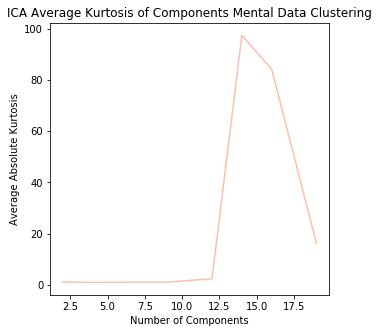

In [43]:
plt.figure(figsize=(5,5))
#sns.set_style("whitegrid")
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(dims, kurt,  alpha=0.5, color = 'coral')
plt.title("ICA Average Kurtosis of Components Mental Data Clustering")
plt.xlabel("Number of Components")
plt.ylabel("Average Absolute Kurtosis")



plt.show()

In [49]:
a = temp.argsort()[-10:][::-1]

In [65]:
a
S_temp = S[:,a]

In [67]:
SSE_ica = defaultdict(dict)
ll_ica = defaultdict(dict)
#adjMI_pca = defaultdict(lambda: defaultdict(dict))
km = kmeans(random_state=10)
gmm = GMM(random_state=10) # Gaussian Matrix
km_ica = kmeans(random_state=10)
gmm_ica = GMM(random_state=10) # Gaussian Matrix

for k in clusters:
        km.set_params(n_clusters=k, random_state=10)
        km_ica.set_params(n_clusters=k, random_state=10)
        gmm.set_params(n_components=k, random_state=10)
        gmm_ica.set_params(n_components=k, random_state=10)
        
        km.fit(train_x_selected)
        km_ica.fit(S_temp)
        #Using the GaussianMixture class of scikit-learn, we can easily create a GMM and run the EM algorithm
        gmm.fit(train_x_selected)
        gmm_ica.fit(S_temp)
        SSE_ica[k]['original'] = km.score(train_x_selected)
        SSE_ica[k]['ica'] = km_ica.score(S_temp)
        ll_ica[k]['original'] = gmm.score(train_x_selected) 
        ll_ica[k]['ica'] = gmm_ica.score(S_temp)    


In [68]:
SSE_ica = (-pd.DataFrame(SSE_ica)).T
#SSE_pca.rename(columns = lambda x: x+' SSE (left)',inplace=True)
ll_ica = pd.DataFrame(ll_ica).T
SSE_ica

,ica,original
2,8.212571,3333.787090
5,5.503827,2441.267966
10,1.966934,1907.510067
15,1.188864,1574.118448
20,0.776707,1408.373268
25,0.572493,1261.031993
30,0.468553,1128.492937
35,0.372321,1021.240074
40,0.308313,936.238275
45,0.270843,846.978052


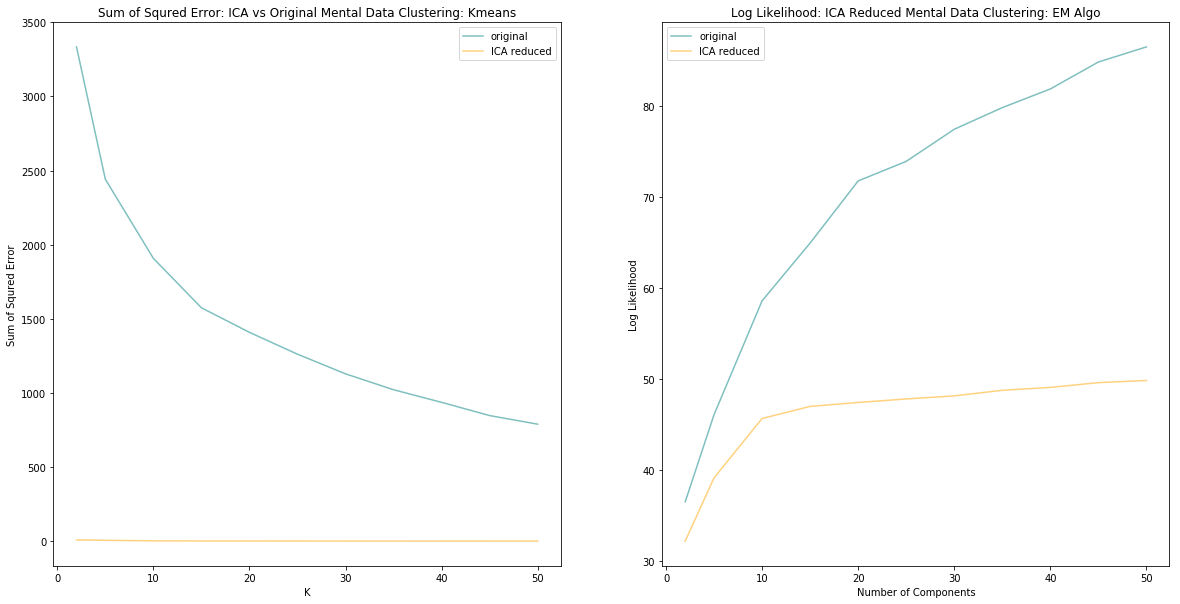

In [69]:
plt.figure(figsize=(20,10))
#sns.set_style("whitegrid")
plt.subplot(121)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(clusters, SSE_ica['original'],  alpha=0.5, label = 'original', color = 'teal')
plt.plot(clusters, SSE_ica['ica'],  alpha=0.5, label = 'ICA reduced', color = 'orange')
plt.title("Sum of Squred Error: ICA vs Original Mental Data Clustering: Kmeans")
plt.xlabel("K")
plt.ylabel("Sum of Squred Error")
plt.legend()
plt.subplot(122)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(clusters, ll_ica['original'], alpha=0.5, label = 'original', color = 'teal')
plt.plot(clusters, ll_ica['ica'], alpha=0.5, label = 'ICA reduced', color = 'orange')
plt.title("Log Likelihood: ICA Reduced Mental Data Clustering: EM Algo")
plt.xlabel("Number of Components")
plt.ylabel("Log Likelihood")
plt.legend()

plt.show()

Random Projection

In [70]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from itertools import product
import numpy as np
from collections import Counter
from sklearn.metrics import accuracy_score as acc
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.base import TransformerMixin,BaseEstimator
import scipy.sparse as sps
from scipy.linalg import pinv

In [71]:
def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]
    
    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

In [72]:
tmp = defaultdict(dict)
for i,dim in product(range(10),dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(train_x_selected), train_x_selected)
tmp =pd.DataFrame(tmp).T
tmp

,0,1,2,3,4,5,6,7,8,9
2,0.289134,0.433972,0.327175,0.345546,0.342639,0.347562,0.407434,0.523055,0.322360,0.229647
4,0.553644,0.565779,0.496184,0.561555,0.487343,0.383929,0.512399,0.609974,0.596013,0.493815
6,0.609323,0.765961,0.494572,0.636197,0.620049,0.632871,0.671862,0.552756,0.540562,0.599733
9,0.738917,0.744150,0.647617,0.705374,0.616056,0.636440,0.632680,0.719669,0.731347,0.703145
12,0.799545,0.749690,0.702114,0.768903,0.707794,0.738021,0.664617,0.784955,0.763999,0.714395
14,0.722522,0.681352,0.717583,0.792732,0.753638,0.789567,0.767124,0.763981,0.824448,0.723722
16,0.750072,0.718475,0.829212,0.832824,0.821240,0.833099,0.756084,0.815533,0.731949,0.852343
19,0.842548,0.801069,0.864109,0.820706,0.815631,0.873540,0.815832,0.822871,0.850018,0.805872


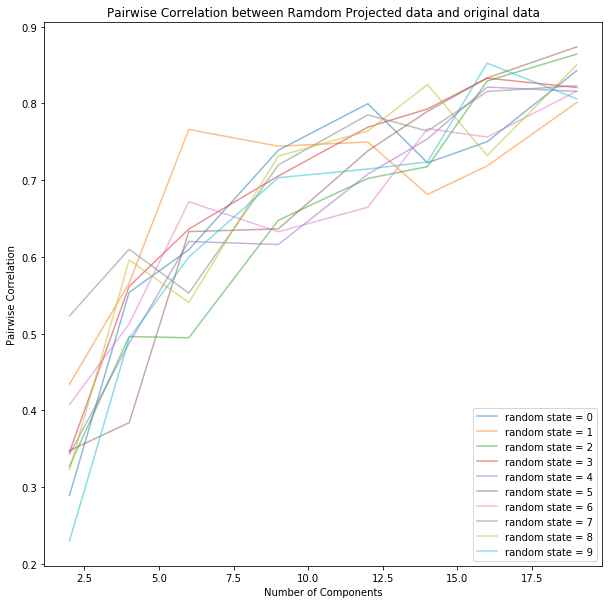

In [73]:
plt.figure(figsize=(10,10))
#sns.set_style("whitegrid")
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
for i in range(10):
    plt.plot(dims, tmp[i], alpha=0.5, label = 'random state = ' + str(i))
    #plt.plot(clusters, SSE_ica['ica'],  alpha=0.5, label = 'ICA reduced', color = 'orange')
plt.title("Pairwise Correlation between Ramdom Projected data and original data")
plt.xlabel("Number of Components")
plt.ylabel("Pairwise Correlation")
plt.legend()
plt.show()

In [74]:
def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T # Unproject projected data
    errors = np.square(X-reconstructed)
    return np.nanmean(errors) 

In [76]:
tmp1 = defaultdict(dict)
for i,dim in product(range(10),dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    rp.fit(train_x_selected)  
    tmp1[dim][i] = reconstructionError(rp, train_x_selected)
tmp1 =pd.DataFrame(tmp1).T

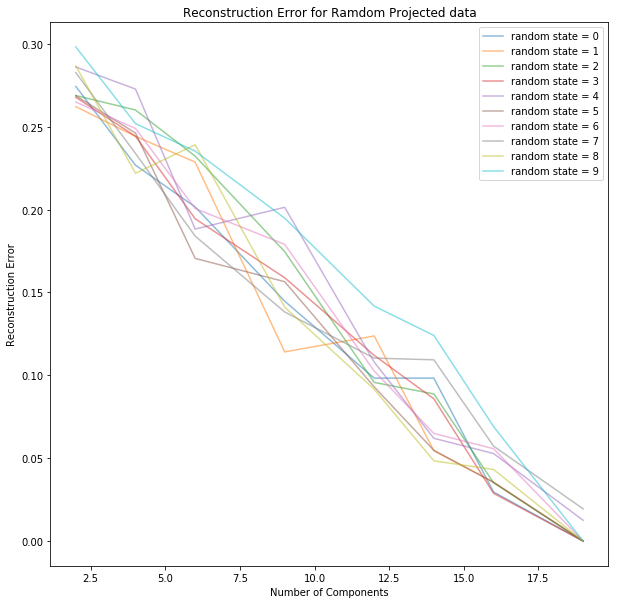

In [77]:
plt.figure(figsize=(10,10))
#sns.set_style("whitegrid")
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
for i in range(10):
    plt.plot(dims, tmp1[i], alpha=0.5, label = 'random state = ' + str(i))
    #plt.plot(clusters, SSE_ica['ica'],  alpha=0.5, label = 'ICA reduced', color = 'orange')
plt.title("Reconstruction Error for Ramdom Projected data")
plt.xlabel("Number of Components")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()

In [78]:
SSE_rp = defaultdict(dict)
ll_rp = defaultdict(dict)
#adjMI_pca = defaultdict(lambda: defaultdict(dict))
km = kmeans(random_state=10)
gmm = GMM(random_state=10) # Gaussian Matrix
km_rp = kmeans(random_state=10)
gmm_rp = GMM(random_state=10) # Gaussian Matrix
x_rp = rp.fit_transform(train_x_selected)
for k in clusters:
        km.set_params(n_clusters=k, random_state=10)
        #km_rp.set_params(n_clusters=k, random_state=10)
        gmm.set_params(n_components=k, random_state=10)
        #gmm_rp.set_params(n_components=k, random_state=10)        
        km.fit(train_x_selected)
        #km_rp.fit(x_rp)
        #Using the GaussianMixture class of scikit-learn, we can easily create a GMM and run the EM algorithm
        gmm.fit(train_x_selected)
        #gmm_rp.fit(x_rp)
        SSE_rp[k]['original'] = km.score(train_x_selected)
        #SSE_rp[k]['rp'] = km_rp.score(x_rp)
        ll_rp[k]['original'] = gmm.score(train_x_selected) 
        #ll_rp[k]['rp'] = gmm_rp.score(x_rp)    

for k in clusters:
    for i in range(10):
        #km.set_params(n_clusters=k, random_state=i)
        km_rp.set_params(n_clusters=k, random_state=i)
        #gmm.set_params(n_components=k, random_state=i)
        gmm_rp.set_params(n_components=k, random_state=i)        
        #km.fit(train_x_hr)
        km_rp.fit(x_rp)
        #Using the GaussianMixture class of scikit-learn, we can easily create a GMM and run the EM algorithm
        #gmm.fit(train_x_hr)
        gmm_rp.fit(x_rp)
        #SSE_rp[k]['original'] = km.score(train_x_hr)
        SSE_rp[k]['rp' + str(i)] = km_rp.score(x_rp)
        #ll_rp[k]['original'] = gmm.score(train_x_hr) 
        ll_rp[k]['rp' + str(i)] = gmm_rp.score(x_rp)    


In [79]:
SSE_rp = (-pd.DataFrame(SSE_rp)).T
#SSE_pca.rename(columns = lambda x: x+' SSE (left)',inplace=True)
ll_rp = pd.DataFrame(ll_rp).T
SSE_rp

,original,rp0,rp1,rp2,rp3,rp4,rp5,rp6,rp7,rp8,rp9
2,3333.787090,2941.273527,2941.276738,2941.234960,2942.092984,2941.276738,2941.250151,2941.234960,2941.234960,2941.234960,2941.234960
5,2441.267966,2141.311742,2131.755690,2140.708266,2138.361232,2136.343701,2140.554116,2129.508803,2133.597505,2135.495622,2138.709391
10,1907.510067,1641.881012,1636.977455,1627.047012,1623.331898,1620.244221,1639.478622,1630.511547,1663.927901,1655.994318,1645.902913
15,1574.118448,1348.066723,1361.793979,1343.949790,1360.858948,1360.195110,1354.806541,1316.958441,1343.181496,1345.441485,1395.385597
20,1408.373268,1177.106220,1166.810477,1178.123063,1192.262691,1179.402919,1179.031597,1178.006144,1166.616453,1176.280103,1162.443312
25,1261.031993,1026.338855,1040.972002,1032.391057,1016.250203,1024.874877,1029.090345,1038.368290,1034.969340,1033.093646,1031.706030
30,1128.492937,905.809013,931.737368,916.938608,908.875402,920.119249,924.291046,910.386004,923.504311,910.277130,920.293590
35,1021.240074,835.602108,823.515036,823.157324,835.937380,830.528712,821.446477,835.599941,818.662975,829.306033,837.357596
40,936.238275,763.359985,760.298933,754.974353,753.808328,741.384265,765.269224,751.829487,757.355711,755.343546,758.792553
45,846.978052,700.739919,687.625139,677.926404,684.622246,682.149879,688.757850,692.542355,682.167629,688.807193,693.975411


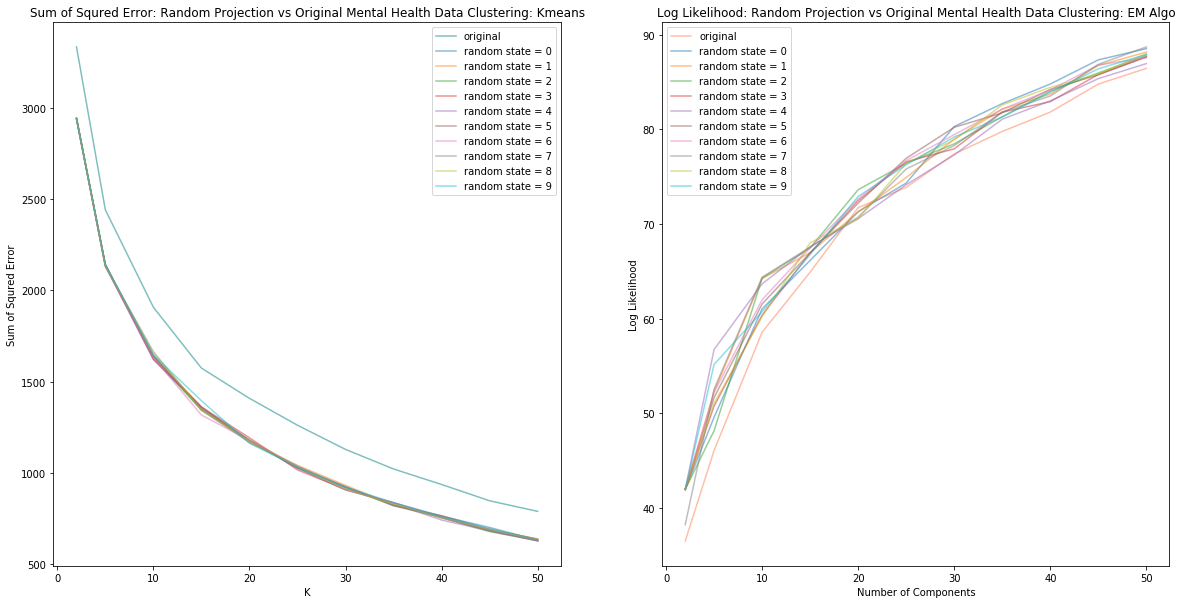

In [80]:
plt.figure(figsize=(20,10))
#sns.set_style("whitegrid")
plt.subplot(121)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(clusters, SSE_rp['original'],  alpha=0.5, label = 'original', color = 'teal')
for i in range(10):
    plt.plot(clusters, SSE_rp['rp'+str(i)],  alpha=0.5, label = 'random state = ' + str(i))
plt.title("Sum of Squred Error: Random Projection vs Original Mental Health Data Clustering: Kmeans")
plt.xlabel("K")
plt.ylabel("Sum of Squred Error")
plt.legend()
plt.subplot(122)
#ax1.set_xlim([0, 50])
#ax1.set_ylim([90000, 9000000])
plt.plot(clusters, ll_ica['original'], alpha=0.5, label = 'original', color = 'coral')
for i in range(10):
    plt.plot(clusters, ll_rp['rp'+str(i)],  alpha=0.5, label = 'random state = ' + str(i))
plt.title("Log Likelihood: Random Projection vs Original Mental Health Data Clustering: EM Algo")
plt.xlabel("Number of Components")
plt.ylabel("Log Likelihood")
plt.legend()

plt.show()

Random Forest

In [81]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#from helpers import   nn_arch,nn_reg,ImportanceSelect
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


In [82]:
class ImportanceSelect(BaseEstimator, TransformerMixin):
    def __init__(self, model, n=1):
        self.model = model
        self.n = n
    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self
    def transform(self, X):
        return X[:,self.model.feature_importances_.argsort()[::-1][:self.n]]

In [83]:
#rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=5,n_jobs=7)
forest = RandomForestRegressor(200)
forest.fit(train_x_selected,target_y)
fs = forest.feature_importances_ 
tmp2 = pd.Series(np.sort(fs)[::-1])
fs

array([1.98794770e-02, 9.29804149e-04, 2.49271225e-02, 8.20000870e-05,
       4.73438690e-02, 4.59764727e-02, 1.62231420e-02, 1.95621718e-01,
       2.10354513e-01, 2.35445689e-01, 2.64587595e-02, 1.73133315e-02,
       2.77487996e-02, 2.21369072e-02, 2.13737100e-02, 3.17934683e-02,
       2.07212107e-02, 1.54760248e-02, 2.01939812e-02])

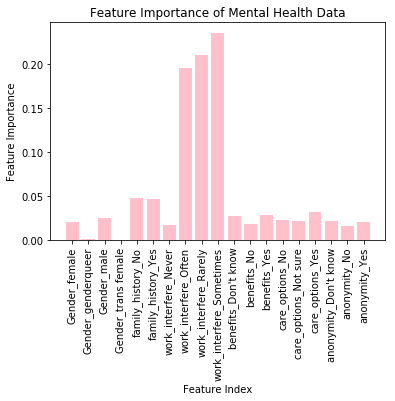

In [85]:
plt.figure()
plt.bar(train_x_selected.columns, fs, align='center', color = 'pink')
plt.ylabel('Feature Importance')
plt.xlabel('Feature Index')
plt.title('Feature Importance of Mental Health Data')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [86]:
train_x_selected.columns

Index(['Gender_female', 'Gender_genderqueer', 'Gender_male',
       'Gender_trans female', 'family_history_No', 'family_history_Yes',
       'work_interfere_Never', 'work_interfere_Often', 'work_interfere_Rarely',
       'work_interfere_Sometimes', 'benefits_Don't know', 'benefits_No',
       'benefits_Yes', 'care_options_No', 'care_options_Not sure',
       'care_options_Yes', 'anonymity_Don't know', 'anonymity_No',
       'anonymity_Yes'],
      dtype='object')

In [88]:
rf_x = train_x_selected[['family_history_No', 'family_history_Yes', 'work_interfere_Often', 'work_interfere_Rarely',
       'work_interfere_Sometimes', "benefits_Don't know",
       'benefits_Yes', 'care_options_No', 'care_options_Not sure',
       'care_options_Yes']]

In [89]:
rf_x.head()

,family_history_No,family_history_Yes,work_interfere_Often,work_interfere_Rarely,work_interfere_Sometimes,benefits_Don't know,benefits_Yes,care_options_No,care_options_Not sure,care_options_Yes
0,1,0,1,0,0,0,1,0,1,0
1,1,0,0,1,0,1,0,1,0,0
2,1,0,0,1,0,0,0,1,0,0
3,0,1,1,0,0,0,0,0,0,1
4,1,0,0,0,0,0,1,1,0,0


In [90]:
SSE_rf = defaultdict(dict)
ll_rf = defaultdict(dict)
#adjMI_pca = defaultdict(lambda: defaultdict(dict))
km = kmeans(random_state=10)
gmm = GMM(random_state=10) # Gaussian Matrix
km_rf = kmeans(random_state=10)
gmm_rf = GMM(random_state=10) # Gaussian Matrix

for k in clusters:
        km.set_params(n_clusters=k, random_state=10)
        km_rf.set_params(n_clusters=k, random_state=10)
        gmm.set_params(n_components=k, random_state=10)
        gmm_rf.set_params(n_components=k, random_state=10)
        
        km.fit(train_x_selected)
        km_rf.fit(rf_x)
        #Using the GaussianMixture class of scikit-learn, we can easily create a GMM and run the EM algorithm
        gmm.fit(train_x_selected)
        gmm_rf.fit(rf_x)
        SSE_rf[k]['original'] = km.score(train_x_selected)
        SSE_rf[k]['rf'] = km_rf.score(rf_x)
        ll_rf[k]['original'] = gmm.score(train_x_selected) 
        ll_rf[k]['rf'] = gmm_rf.score(rf_x)    



In [91]:
SSE_rf = (-pd.DataFrame(SSE_rf)).T
#SSE_pca.rename(columns = lambda x: x+' SSE (left)',inplace=True)
ll_rf = pd.DataFrame(ll_rf).T

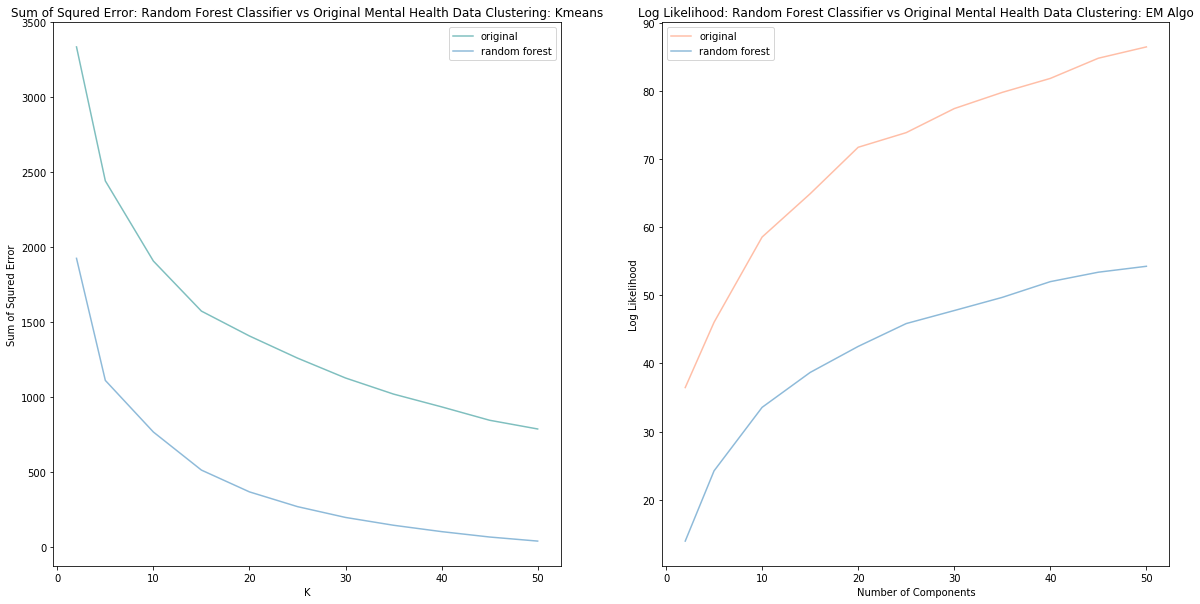

In [92]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(clusters, SSE_rf['original'],  alpha=0.5, label = 'original', color = 'teal')
plt.plot(clusters, SSE_rf['rf'],  alpha=0.5, label = 'random forest')
plt.title("Sum of Squred Error: Random Forest Classifier vs Original Mental Health Data Clustering: Kmeans")
plt.xlabel("K")
plt.ylabel("Sum of Squred Error")
plt.legend()
plt.subplot(122)
plt.plot(clusters, ll_rf['original'], alpha=0.5, label = 'original', color = 'coral')
plt.plot(clusters, ll_rf['rf'],  alpha=0.5, label = 'random forest')
plt.title("Log Likelihood: Random Forest Classifier vs Original Mental Health Data Clustering: EM Algo")
plt.xlabel("Number of Components")
plt.ylabel("Log Likelihood")
plt.legend()

plt.show()

In [94]:
# save all the DR dataset and apply NN
temp.to_pickle("originalLabel")






AttributeError: 'numpy.ndarray' object has no attribute 'to_pickle'

In [93]:
#Keras_NN_Classifier: deep feed-forward network with categorical crossentropy objective.
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils
from sklearn import preprocessing
from sklearn.base import BaseEstimator
from keras.wrappers.scikit_learn import KerasClassifier

ModuleNotFoundError: No module named 'tensorflow'